# PlantCV sorghum leaf angle workflow
The image data in this exercise is from Veley et al. 2017. 

## Citation
Veley KM, Berry JC, Fentress SJ, Schachtman DP, Baxter I, Bart R. 2017. High-throughput profiling and analysis of plant responses over time to abiotic stress. *Plant Direct* 1:e00023. DOI: [10.1002/pld3.23](https://doi.org/10.1002/pld3.23).

Import PlantCV and dependencies

***

In [3]:
%matplotlib notebook
from plantcv import plantcv as pcv
import matplotlib 

Make the plot size bigger for the workshop livestream

***

In [4]:
matplotlib.rcParams["figure.figsize"] = [8, 8]

Create a simple class for storing input variables. This is not required but makes it easier to convert your notebook into a workflow script later

***

In [17]:
class options:
    def __init__(self):
        # Input image path/filename
        self.image = "sorghum_images/VIS_SV_0_z1_h1_g0_e65_v500_207716_2016-06-27-08-41-48_Fa016AC031775.png"
        # Debug mode = None, "plot", or "print"
        self.debug = "plot"
        # Store output images (True/False)
        self.writeimg = False
        # Results path/filename
        self.result = "results.txt"
        # Image output directory path
        self.outdir = "."

# Initialize options
args = options()
# Set PlantCV debug mode to input debug method
pcv.params.debug = args.debug
# Increase text size in plots
pcv.params.text_size = 20
pcv.params.text_thickness = 10

Use PlantCV to read in the input image. The function outputs an image as a NumPy array, the path to the file, and the image filename

***

<IPython.core.display.Javascript object>


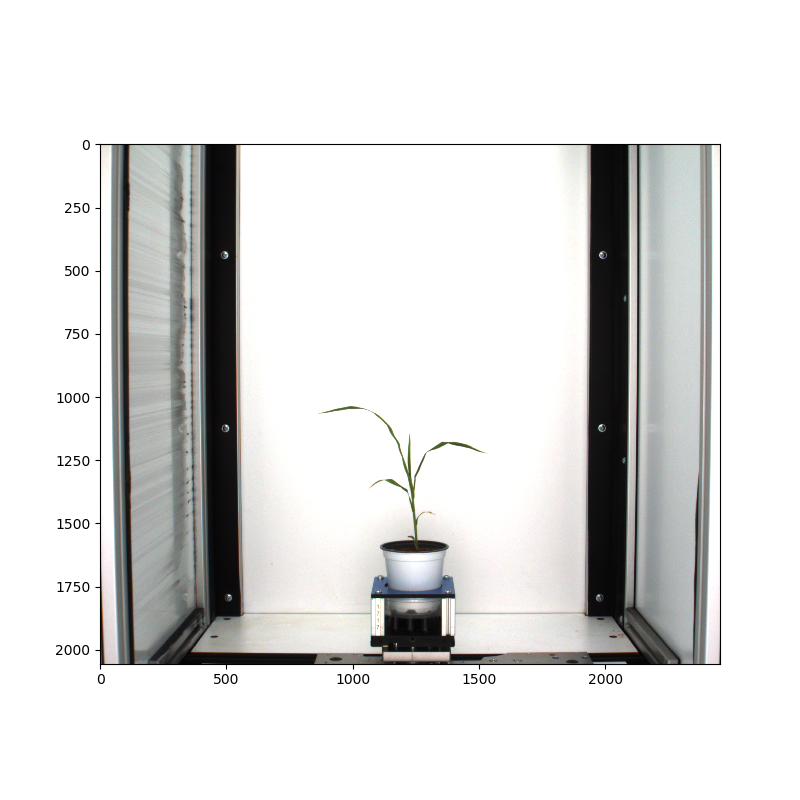

In [6]:
img, path, filename = pcv.readimage(filename=args.image)

## Segmentation

We will use simple color segmentation to identify plant pixels and remove background pixels. Color images are stored in RGB format but it can be more useful to utilize other colorspace representations for segmentation. We can use a PlantCV visualization feature to observe the component channels of two supported colorspaces (HSV and LAB)

***

<IPython.core.display.Javascript object>


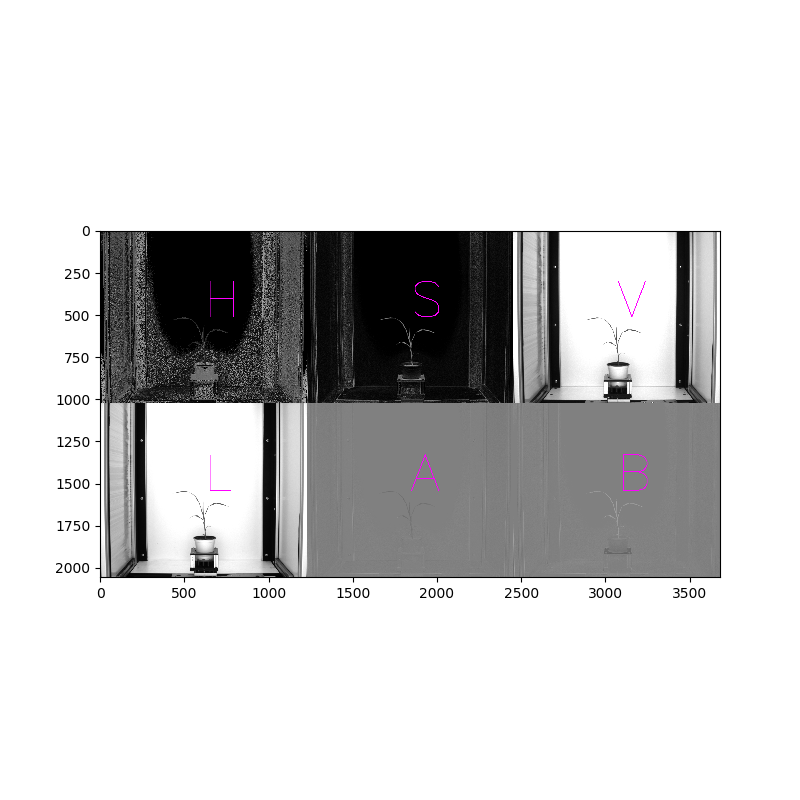

In [18]:
cs_plot = pcv.visualize.colorspaces(rgb_img=img, original_img=False)

### Saturation channel

Convert the RGB image to HSV colorspace and extract the saturation channel

***

<IPython.core.display.Javascript object>


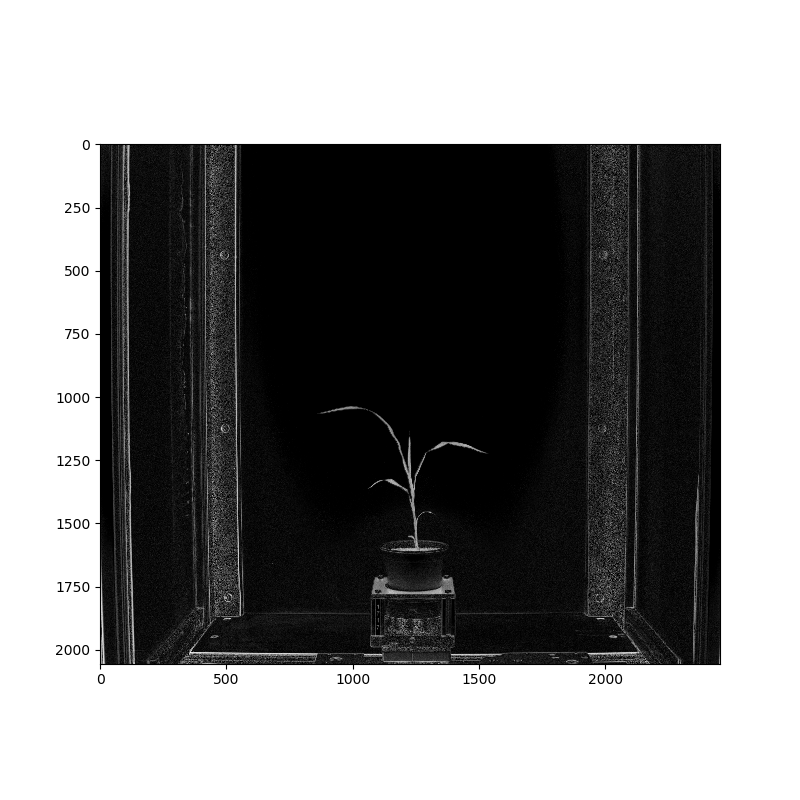

In [23]:
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')

Use a binary threshold to set an inflection value where all pixels in the grayscale saturation image below the threshold get set to zero (pure black) and all pixels at or above the threshold get set to 255 (pure white)

***

<IPython.core.display.Javascript object>


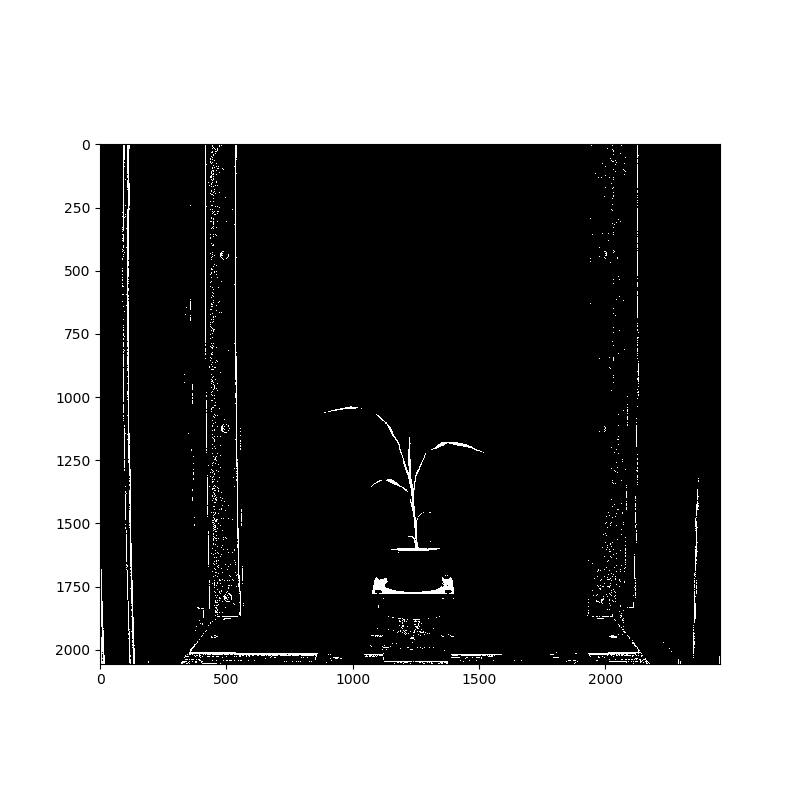

In [24]:
s_thresh = pcv.threshold.binary(gray_img=s, threshold=80, max_value=255, object_type='light')

### Blue-yellow channel

Convert the RGB image to LAB colorspace and extract the blue-yellow channel

***

<IPython.core.display.Javascript object>


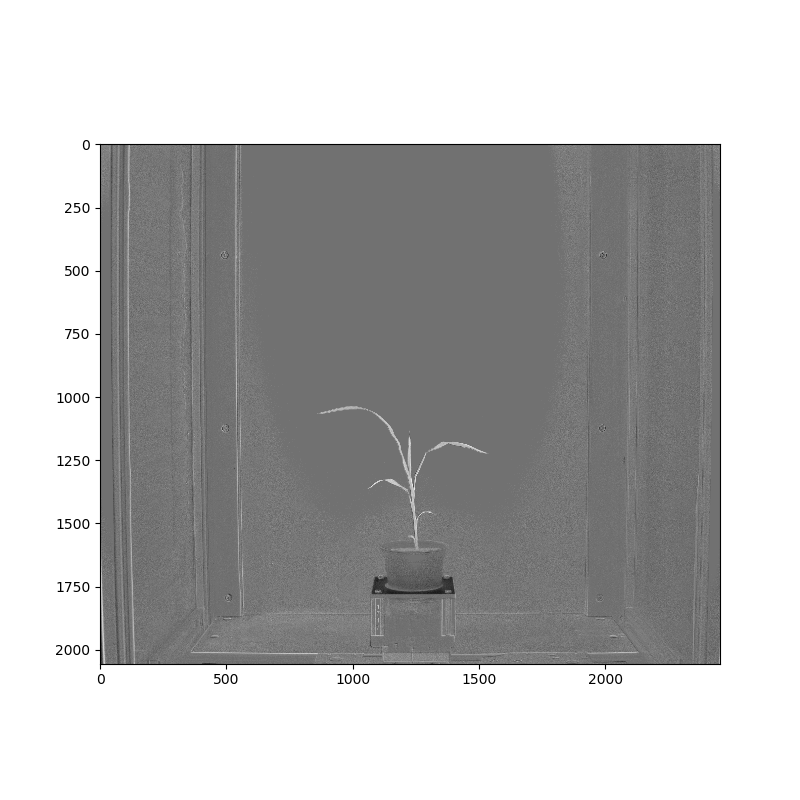

In [25]:
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')

Use a binary threshold to set an inflection value where all pixels in the grayscale blue-yellow image below the threshold get set to zero (pure black) and all pixels at or above the threshold get set to 255 (pure white)

***

<IPython.core.display.Javascript object>


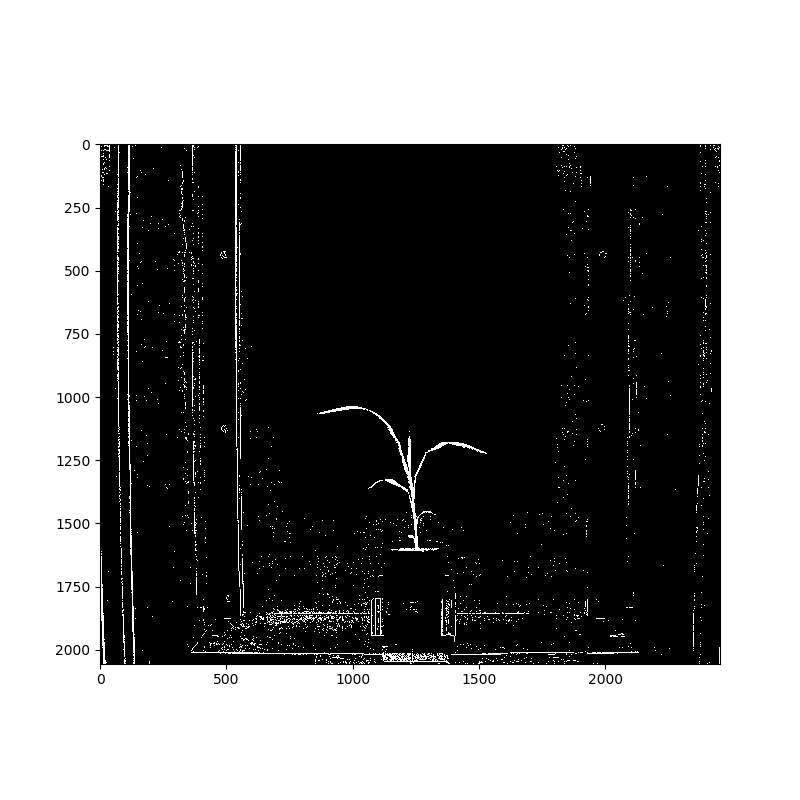

In [26]:
b_thresh = pcv.threshold.binary(gray_img=b, threshold=134, max_value=255, object_type='light')

### Green-magenta channel

Convert the RGB image to LAB colorspace and extract the green-magenta channel

***

<IPython.core.display.Javascript object>


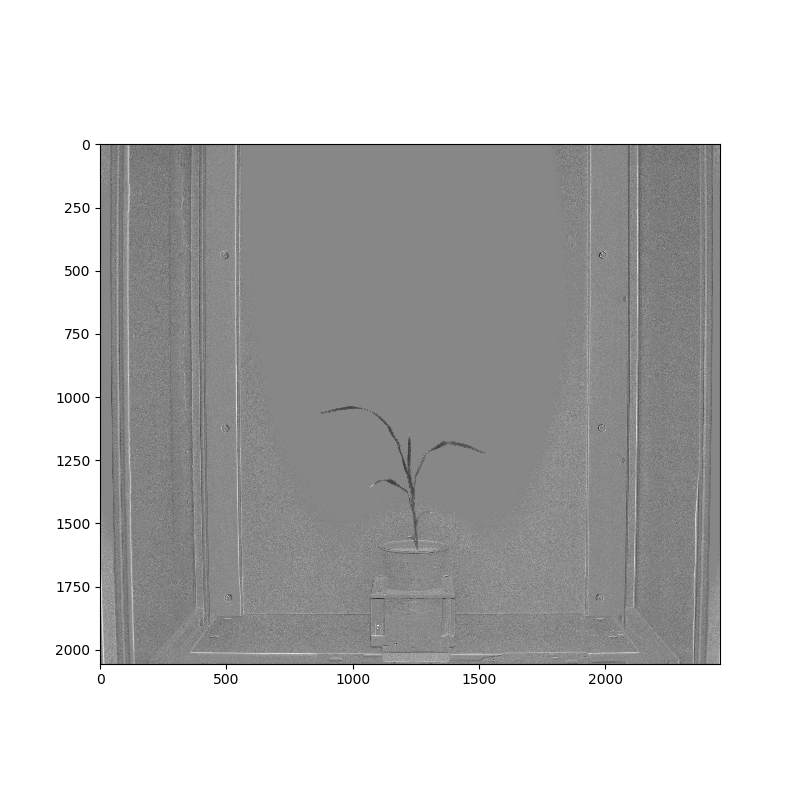

In [27]:
a = pcv.rgb2gray_lab(rgb_img=img, channel='a')

In the green-magenta image the plant pixels are darker than the background. Setting object_type="dark" will invert the image first and then use a binary threshold to set an inflection value where all pixels in the grayscale green-magenta image below the threshold get set to zero (pure black) and all pixels at or above the threshold get set to 255 (pure white)

***

<IPython.core.display.Javascript object>


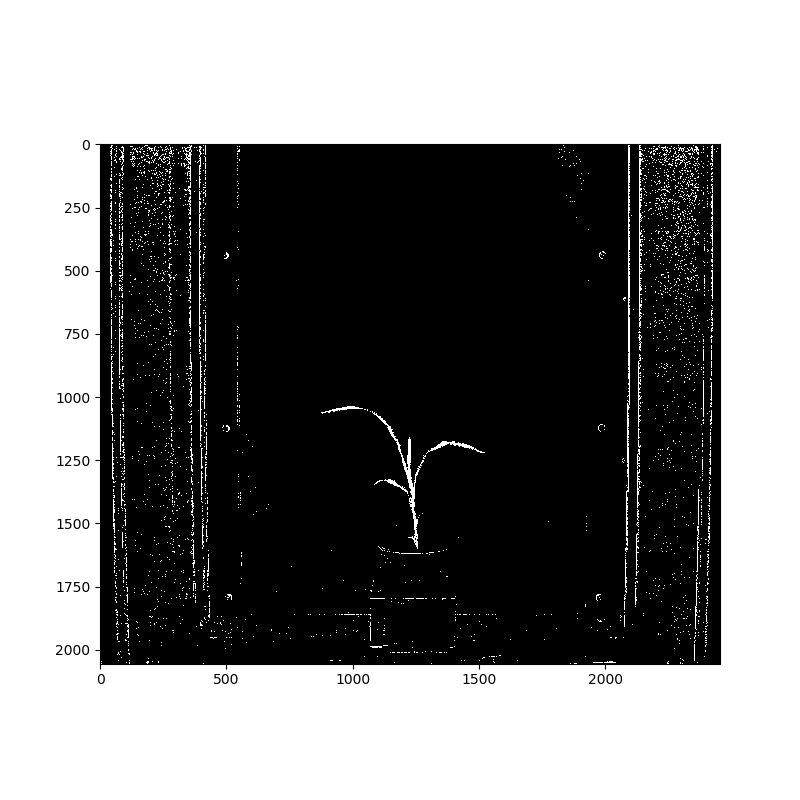

In [28]:
a_thresh = pcv.threshold.binary(gray_img=a, threshold=122, max_value=255, object_type='dark')

Combine the binary images for the saturation and blue-yellow channels. The "or" operator returns a binary image that is white when a pixel was white in either or both input images

***

<IPython.core.display.Javascript object>


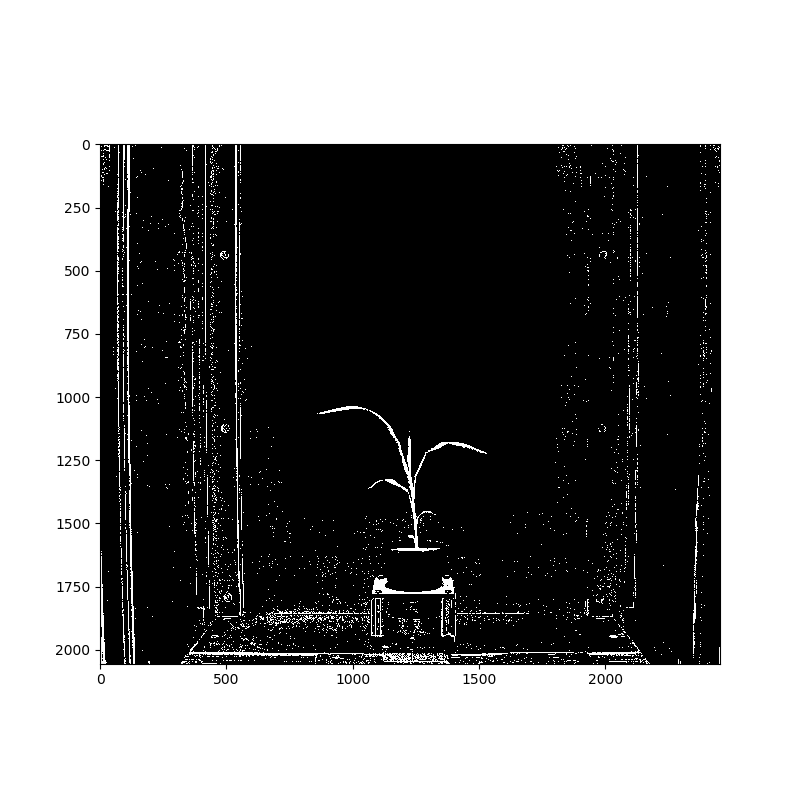

In [29]:
bs = pcv.logical_or(bin_img1=s_thresh, bin_img2=b_thresh)

Combine the binary images for the combined saturation and blue-yellow channels and the green-magenta channel. The "or" operator returns a binary image that is white when a pixel was white in either or both input images

***

<IPython.core.display.Javascript object>


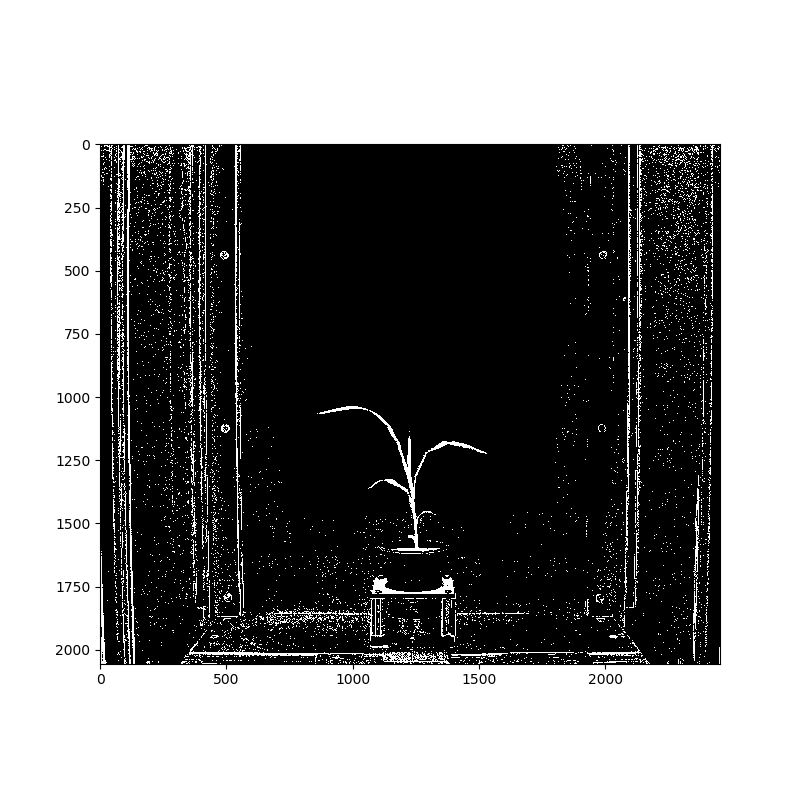

In [30]:
bsa = pcv.logical_or(bin_img1=bs, bin_img2=a_thresh)

The combined binary image labels plant pixels well but the background still has pixels labeled as foreground. Small white noise (salt) in the background can be removed by filtering white objects in the image by size and setting a size threshold where smaller objects can be removed

***

<IPython.core.display.Javascript object>


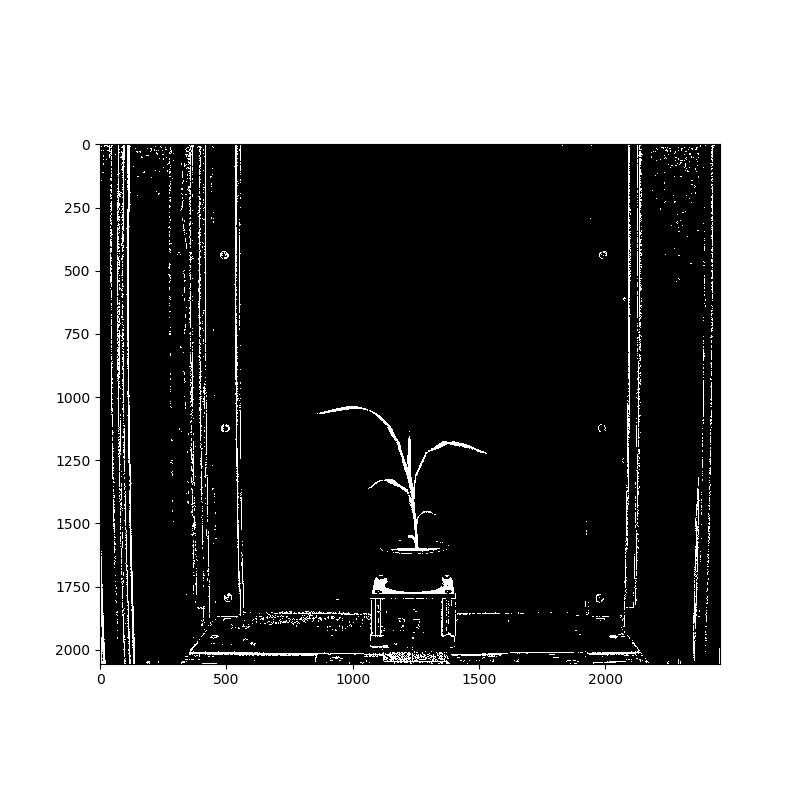

In [33]:
bsa_fill1 = pcv.fill(bin_img=bsa, size=15) # Fill small noise

Before more stringent size filtering is done we want to connect plant parts that may still be disconnected from the main plant. Use a dilation to expand the boundary of white regions. Ksize is the size of a box scanned across the image and i is the number of times a scan is done

***

<IPython.core.display.Javascript object>


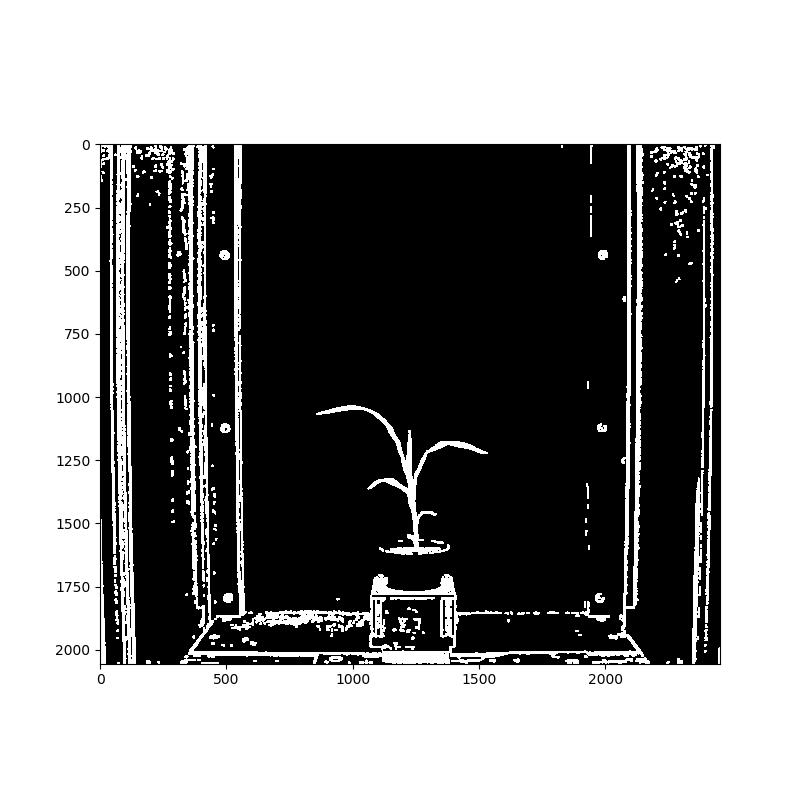

In [34]:
bsa_fill2 = pcv.dilate(gray_img=bsa_fill1, ksize=3, i=3)

Remove small objects by size again but use a higher threshold

***

<IPython.core.display.Javascript object>


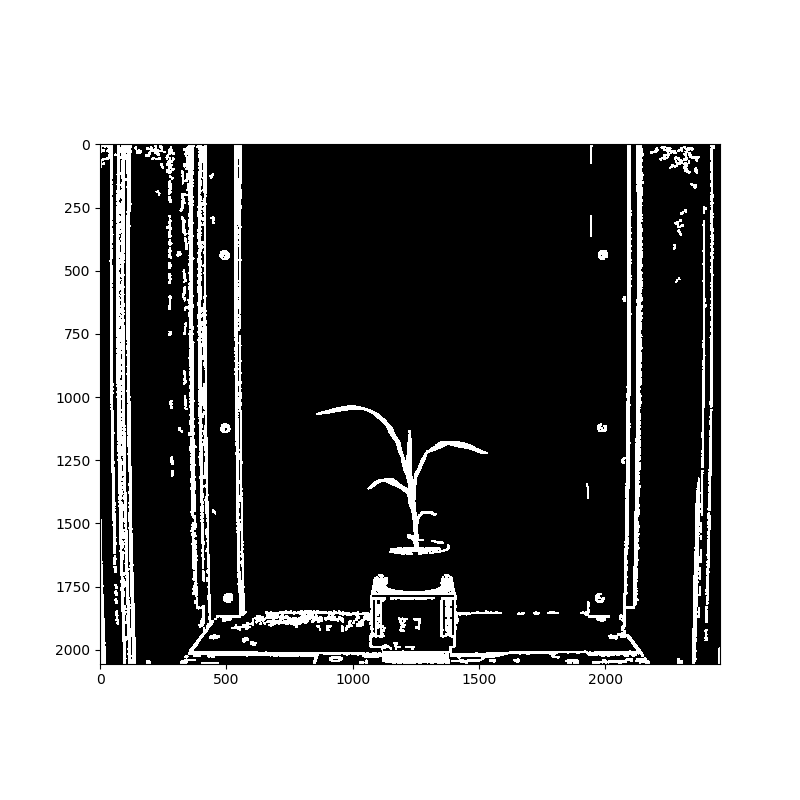

In [35]:
bsa_fill3 = pcv.fill(bin_img=bsa_fill2, size=250)

Use the binary image to identify objects or connected components.

***

<IPython.core.display.Javascript object>


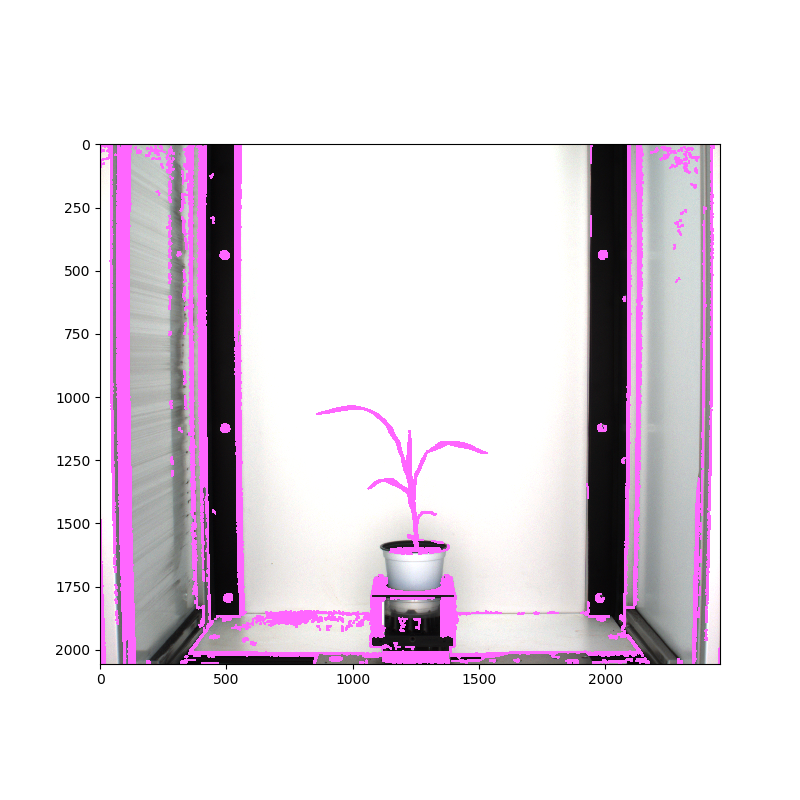

In [40]:
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=bsa_fill3)

Because the background still contains pixels labeled as foreground, the object list contains background. Because these images were collected in an automated system the plant is always centered in the image at the same position each time. Define a region of interest (ROI) to set the area where we expect to find plant pixels. PlantCV can make simple ROI shapes like rectangles, circles, etc. but here we use a custom ROI to fit a polygon around the plant area

***

<IPython.core.display.Javascript object>


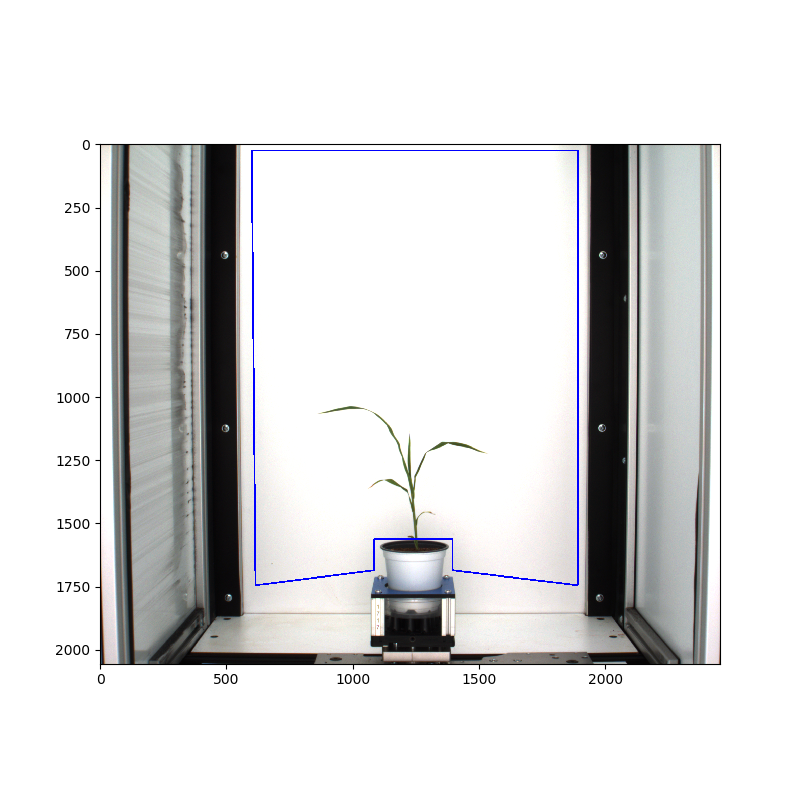

In [41]:
roi_custom, roi_hier_custom = pcv.roi.custom(img=img, vertices=[[1085, 1560], [1395, 1560], [1395, 1685], [1890, 1744], [1890, 25], [600, 25], [615, 1744], [1085, 1685]])

Use the ROI to filter out objects found outside the ROI. When `roi_type = "cutto"` objects outside the ROI are cropped out. The default `roi_type` is "partial" which allows objects to overlap the ROI and be retained 

***

<IPython.core.display.Javascript object>


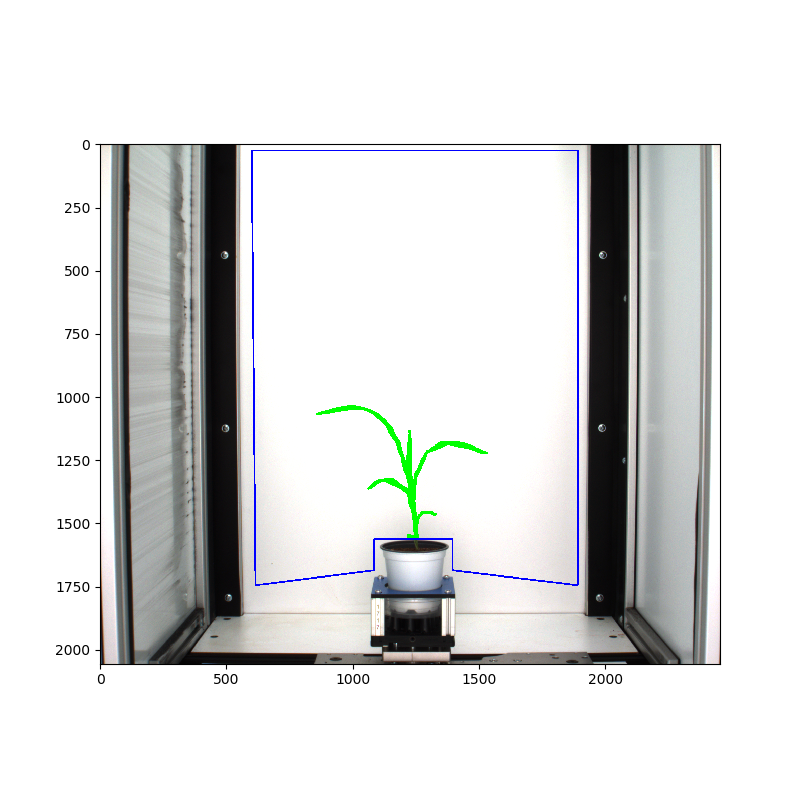

<IPython.core.display.Javascript object>


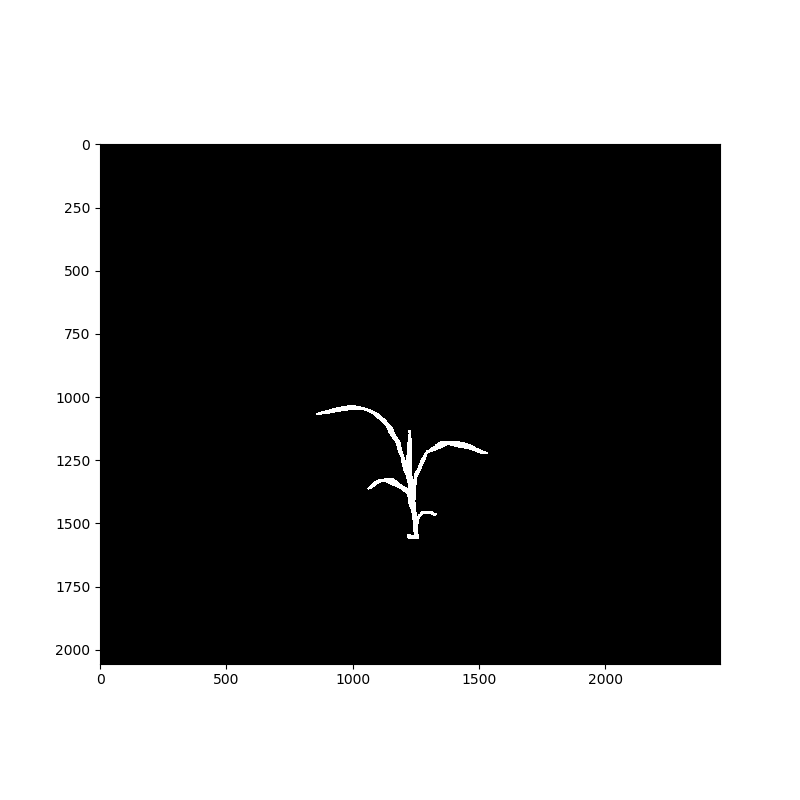

In [42]:
roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi_custom, roi_hierarchy=roi_hier_custom, object_contour=id_objects, obj_hierarchy=obj_hierarchy, roi_type='cutto')

Filter remaining objects by size again to remove any remaining background objects

***

<IPython.core.display.Javascript object>


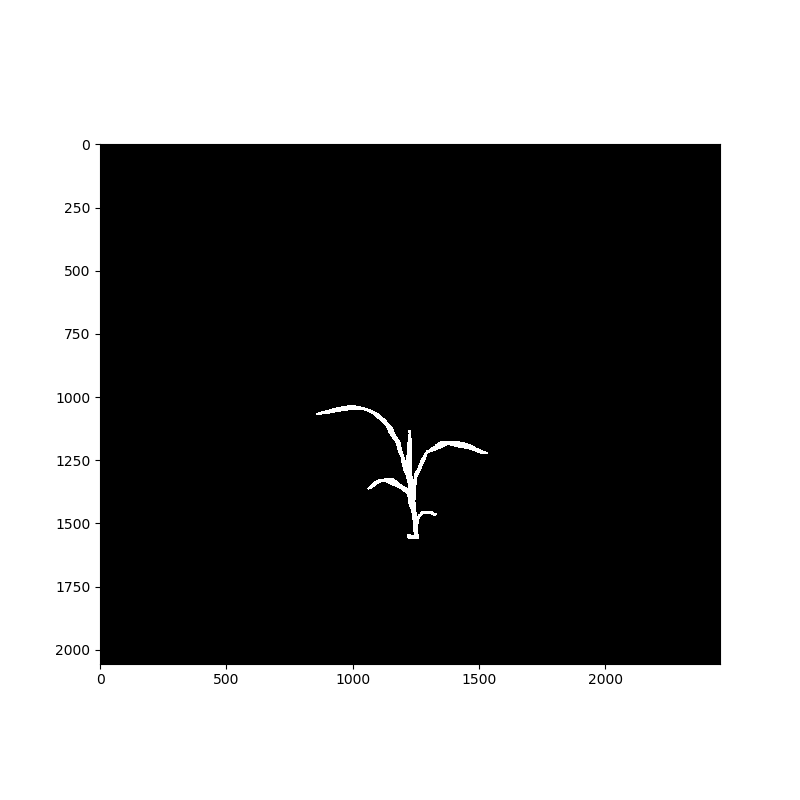

In [43]:
filled_mask1 = pcv.fill(bin_img=kept_mask, size=350)

Use a closing operation to first dilate (expand) and then erode (shrink) the plant to fill in any additional gaps in leaves or stems

***

<IPython.core.display.Javascript object>


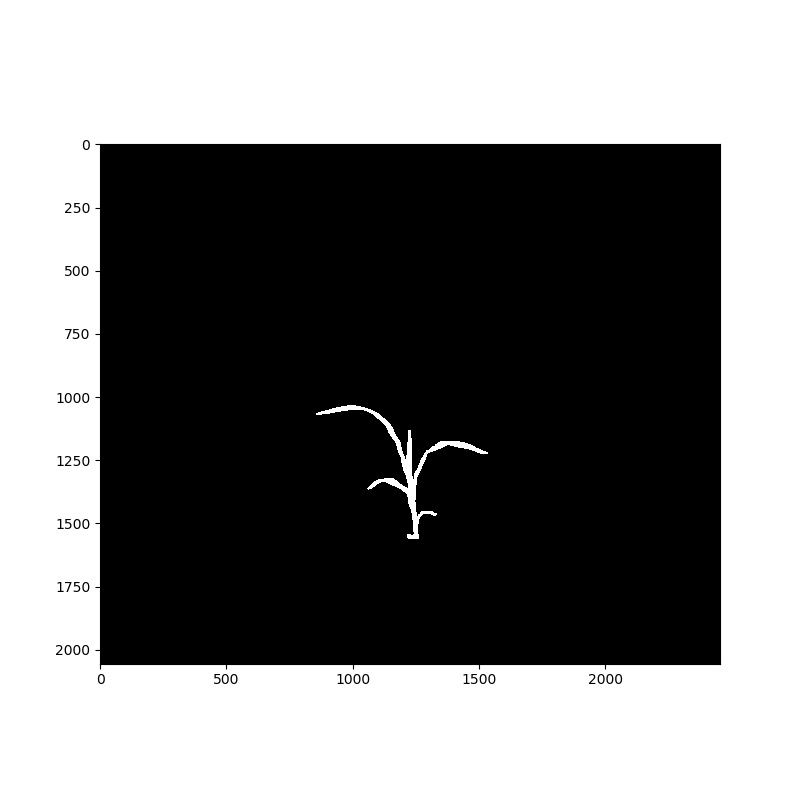

In [44]:
filled_mask2 = pcv.closing(gray_img=filled_mask1)

Remove holes or dark spot noise (pepper) in the plant binary image

***

<IPython.core.display.Javascript object>


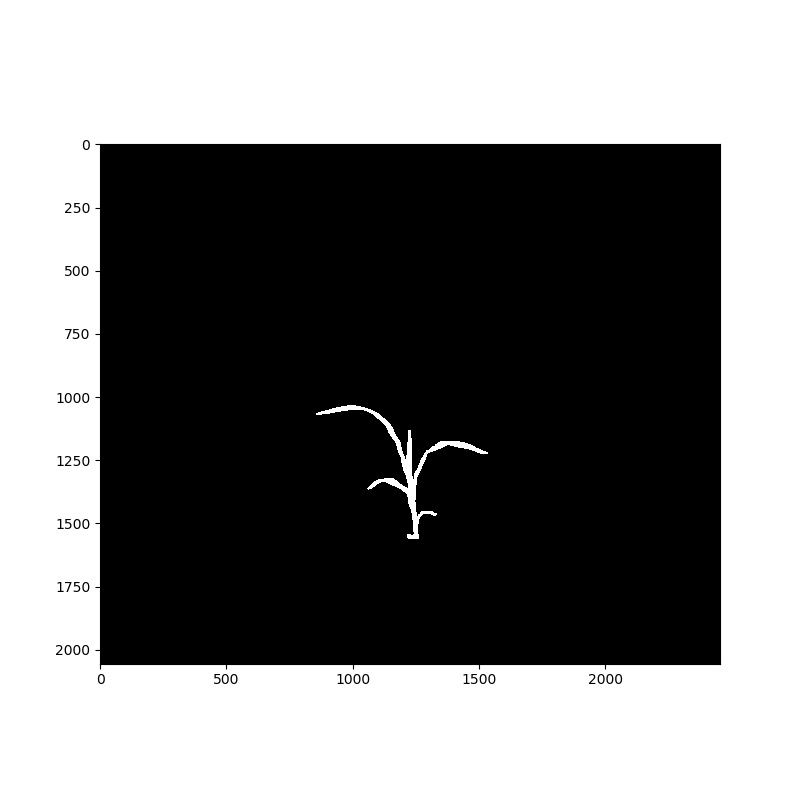

In [45]:
filled_mask3 = pcv.fill_holes(filled_mask2)

With the clean binary image identify the contour of the plant

***

/Users/nfahlgren/GitHub/plantcv/plantcv/plantcv/plot_image.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


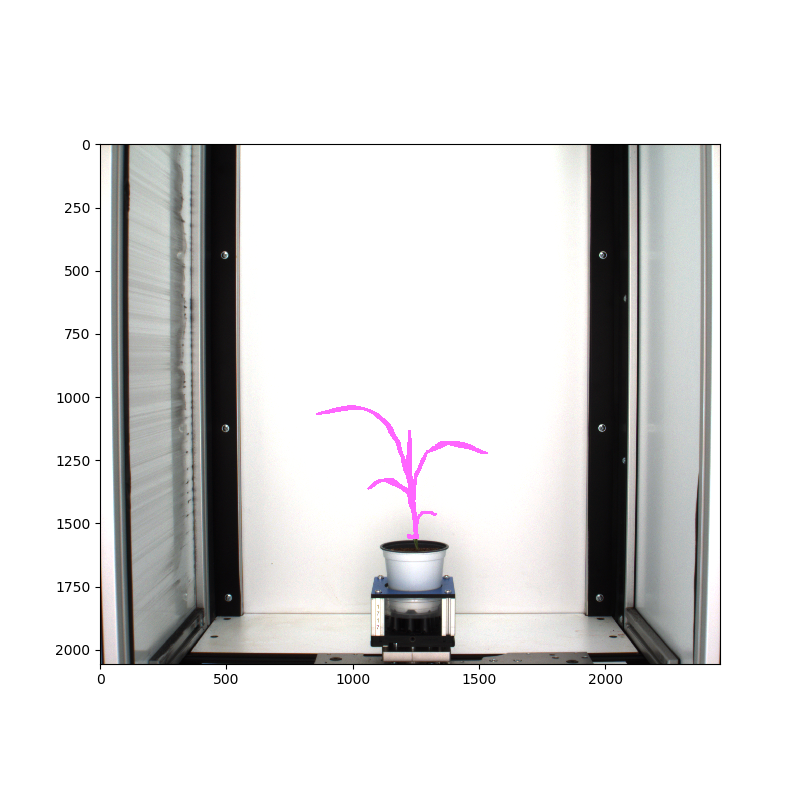

In [46]:
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=filled_mask3)

Because a plant or object of interest may be composed of multiple contours, it is required to combine all remaining contours into a single contour before measurements can be done

***

<IPython.core.display.Javascript object>


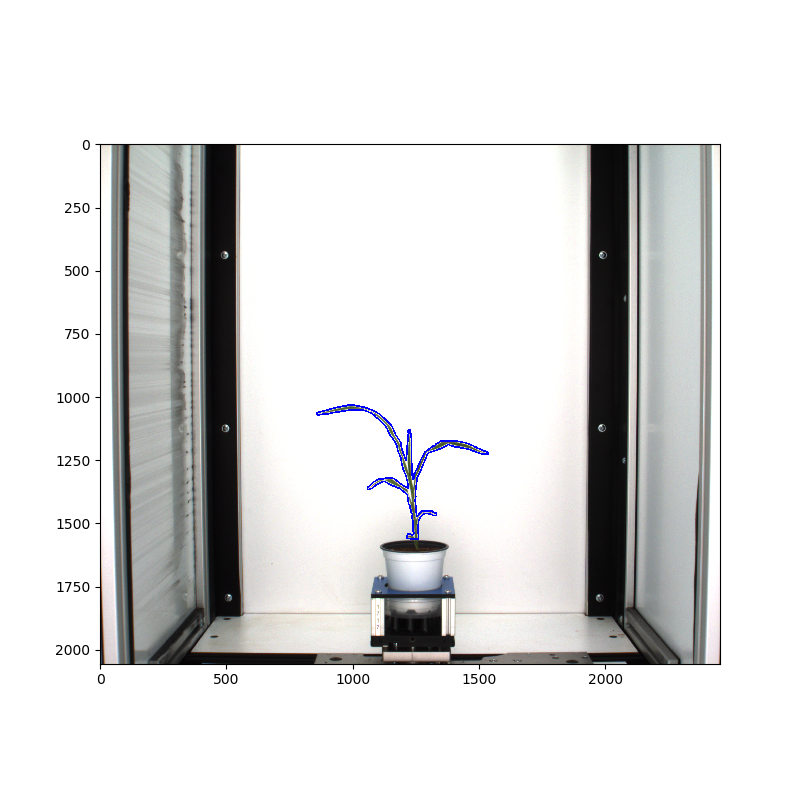

In [47]:
obj, mask = pcv.object_composition(img=img, contours=id_objects, hierarchy=obj_hierarchy)

## Measurements

PlantCV has several built-in measurement or analysis methods. Here, basic measurements of size and shape are done. Additional typical modules would include plant height (`pcv.analyze_bound_horizontal`) and color (`pcv.analyze_color`)

***

/Users/nfahlgren/GitHub/plantcv/plantcv/plantcv/plot_image.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


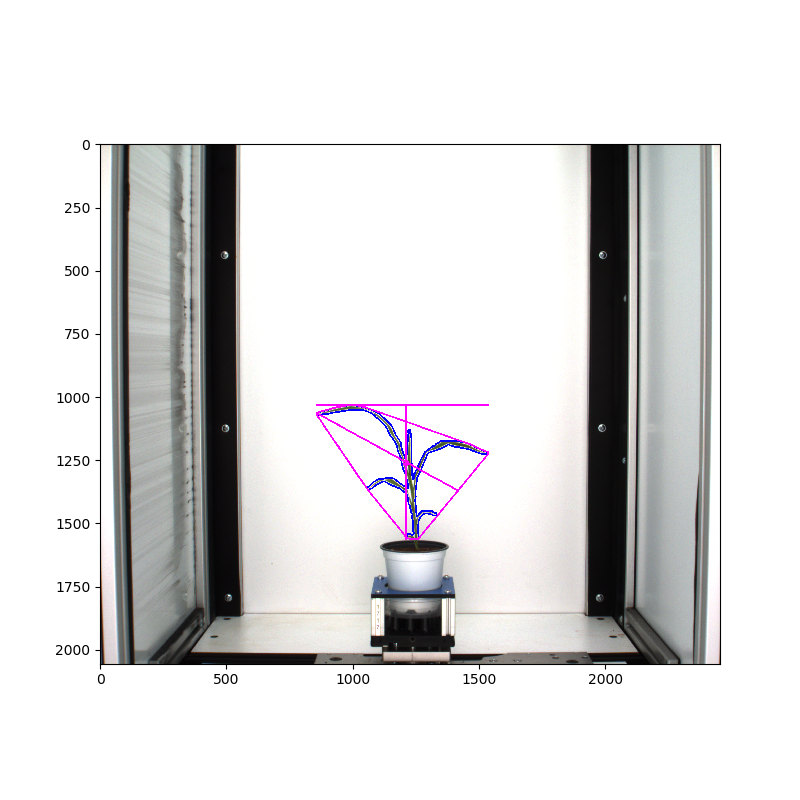

In [48]:
shape_img = pcv.analyze_object(img=img, obj=obj, mask=mask)

## Morphology workflow

Update a few PlantCV parameters for plotting purposes

***

In [56]:
pcv.params.text_size = 1.5
pcv.params.text_thickness = 5
pcv.params.line_thickness = 15

Convert the plant mask into a "skeletonized" image where each path along the stem and leaves are a single pixel wide

***

<IPython.core.display.Javascript object>


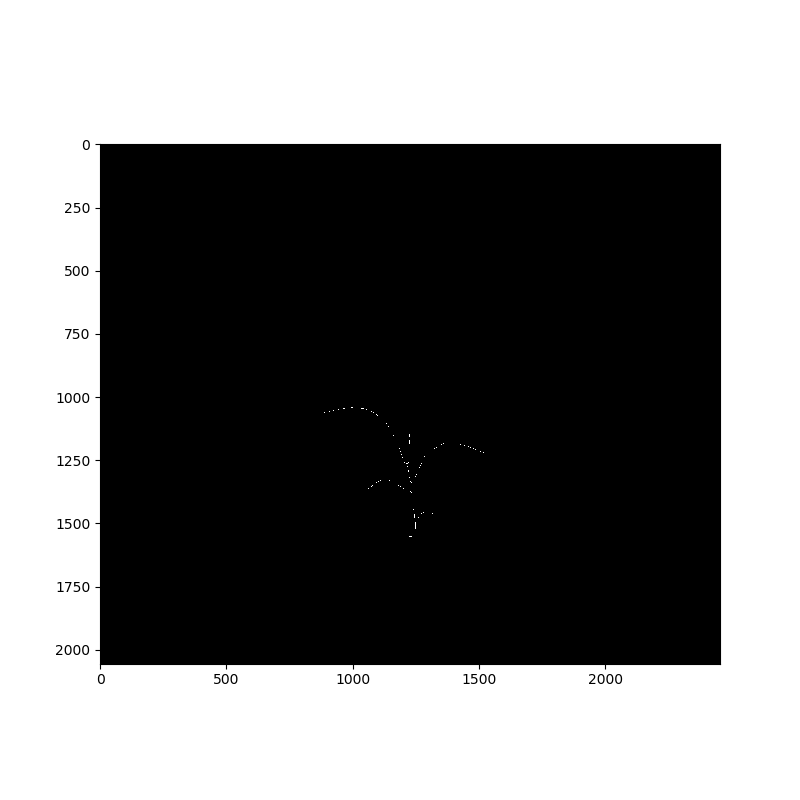

In [58]:
skel = pcv.morphology.skeletonize(mask=mask)

Sometimes wide parts of leaves or stems are skeletonized in the direction perpendicular to the main path. These "barbs" or "spurs" can be removed by pruning the skeleton to remove small paths. Pruning will also separate the individual path segments (leaves and stem parts)

***

<IPython.core.display.Javascript object>


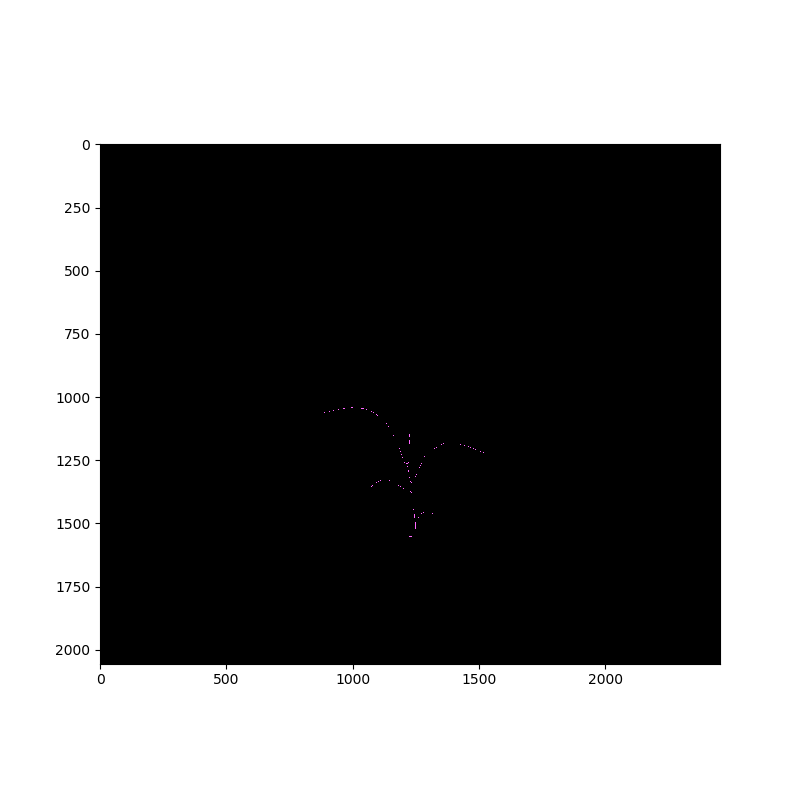

<IPython.core.display.Javascript object>


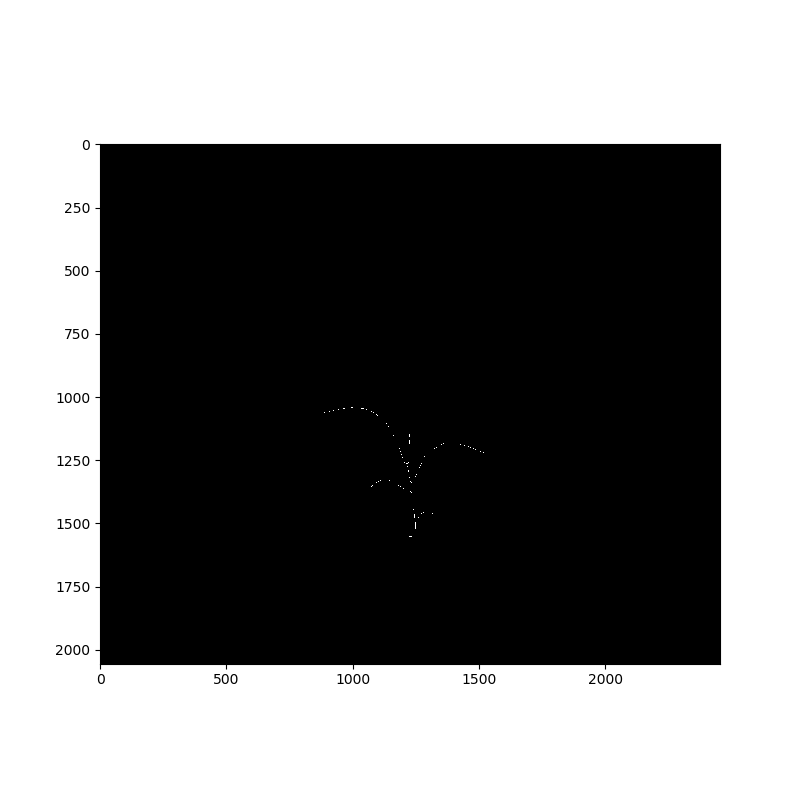

<IPython.core.display.Javascript object>


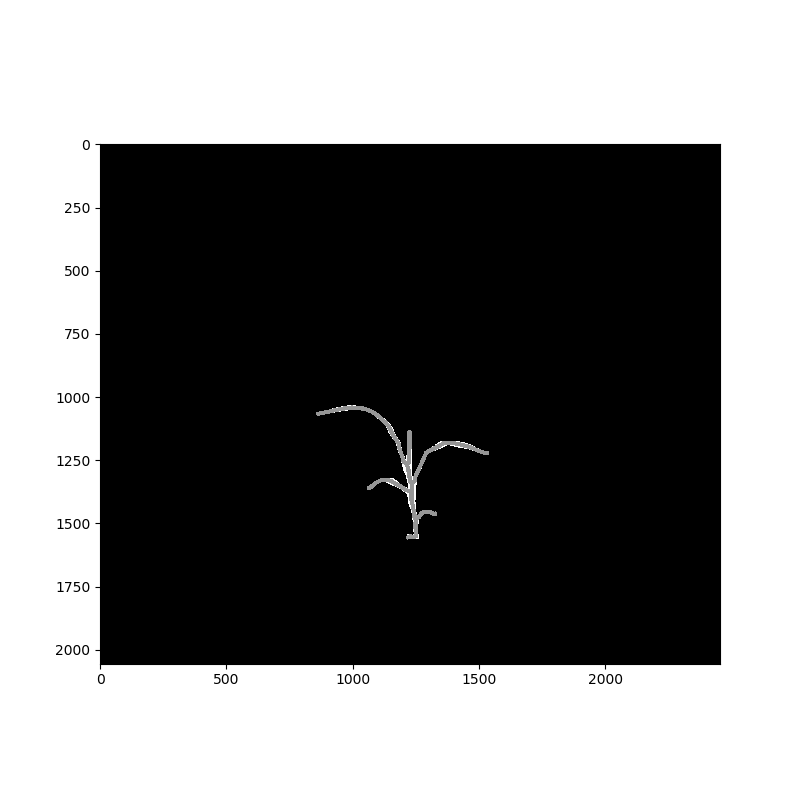

<IPython.core.display.Javascript object>


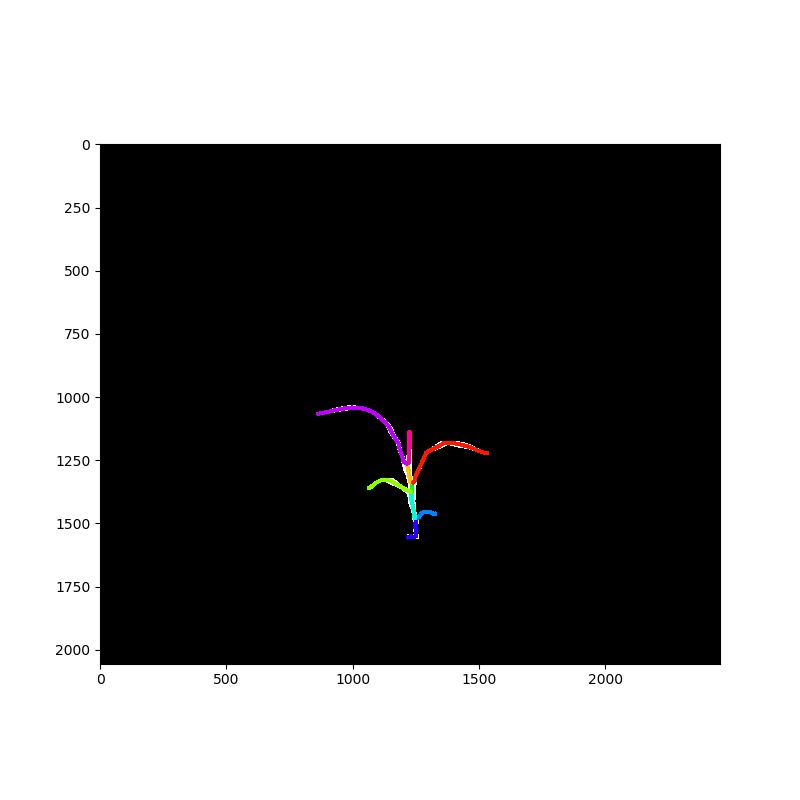

In [60]:
pruned, segmented_img, segment_objects = pcv.morphology.prune(skel_img=skel, size=30, mask=mask)

<IPython.core.display.Javascript object>


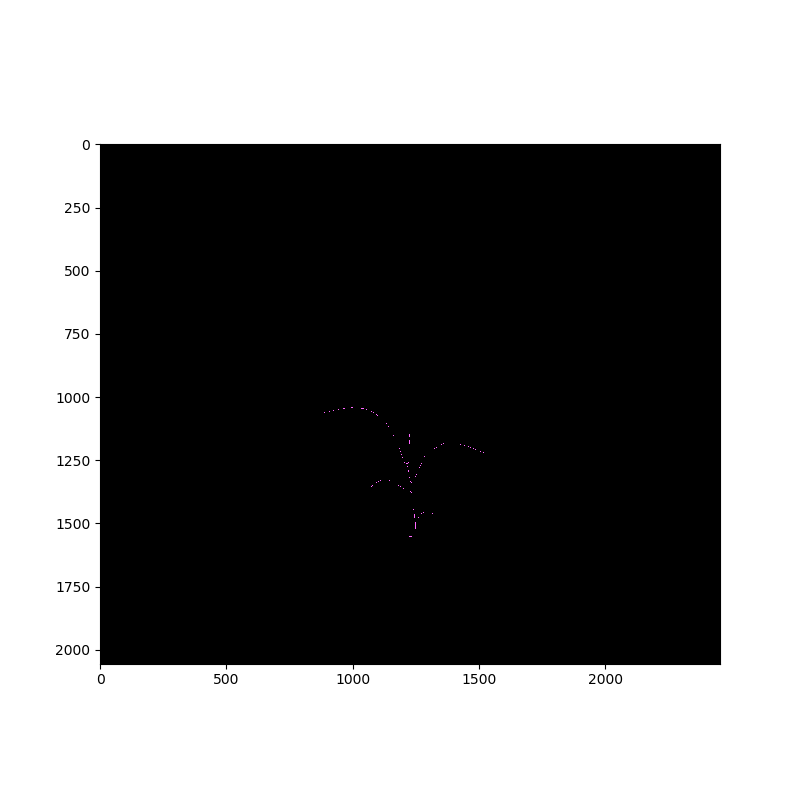

<IPython.core.display.Javascript object>


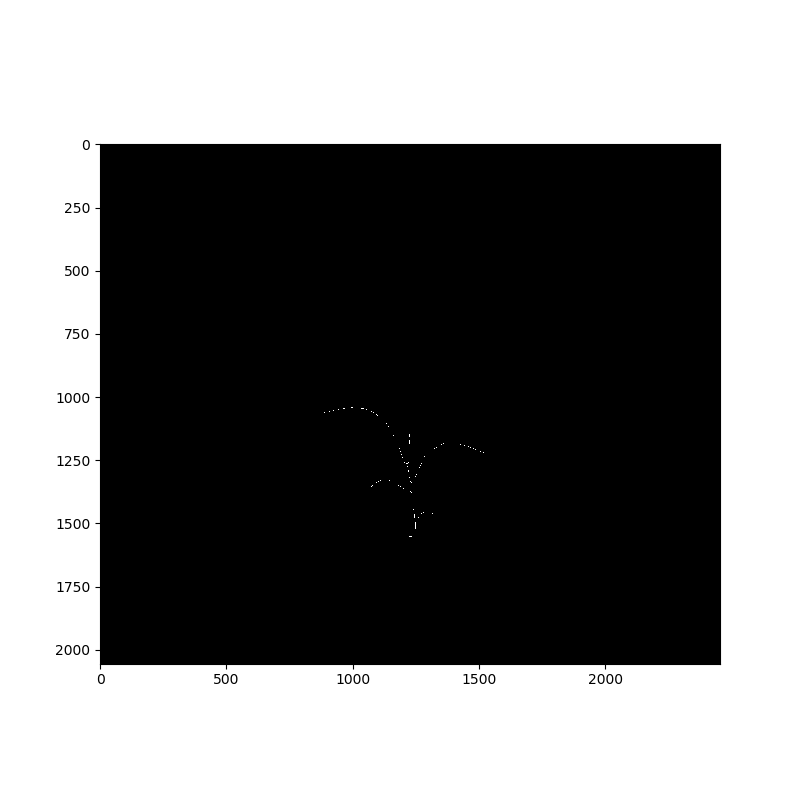

<IPython.core.display.Javascript object>


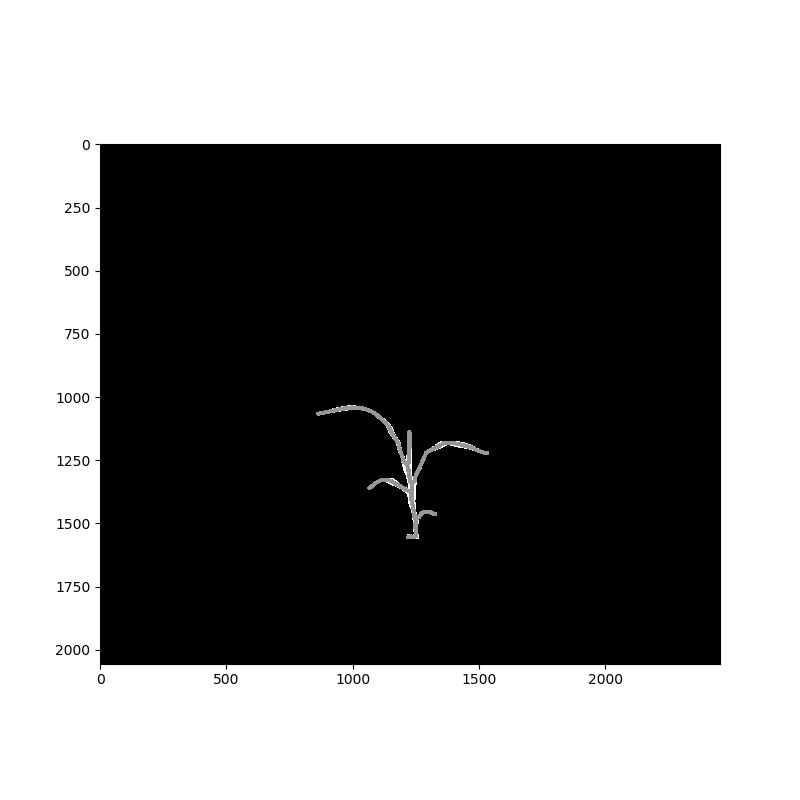

<IPython.core.display.Javascript object>


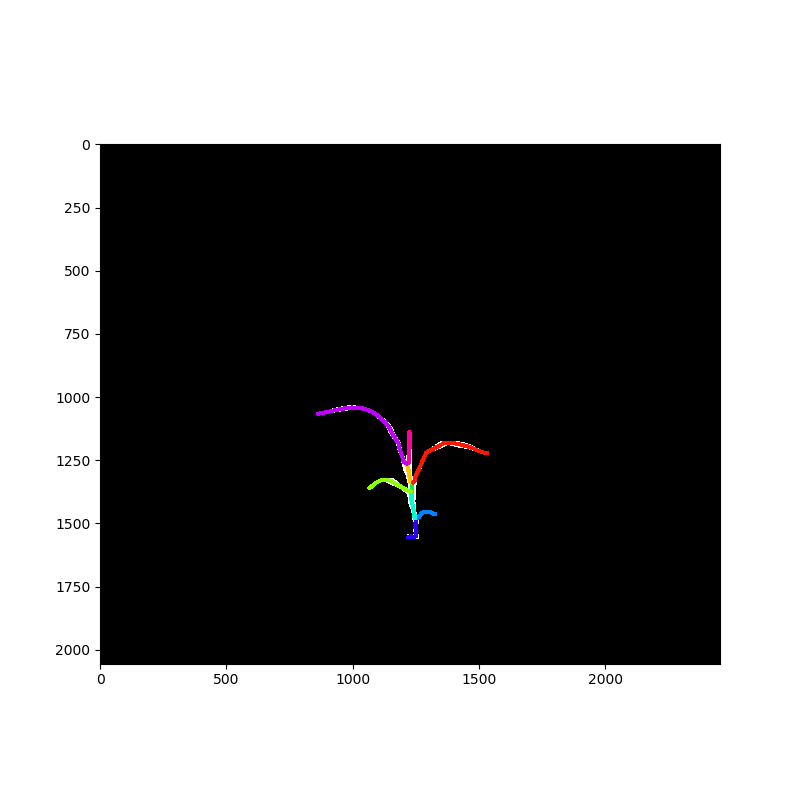

In [61]:
pruned, segmented_img, segment_objects = pcv.morphology.prune(skel_img=pruned, size=3, mask=mask)

Leaf and stem segments above are separated but only into individual paths. We can sort the segments into stem and leaf paths by identifying primary segments (stems; those that end in a branch point) and secondary segments (leaves; those that begin at a branch point and end at a tip point)

***

<IPython.core.display.Javascript object>


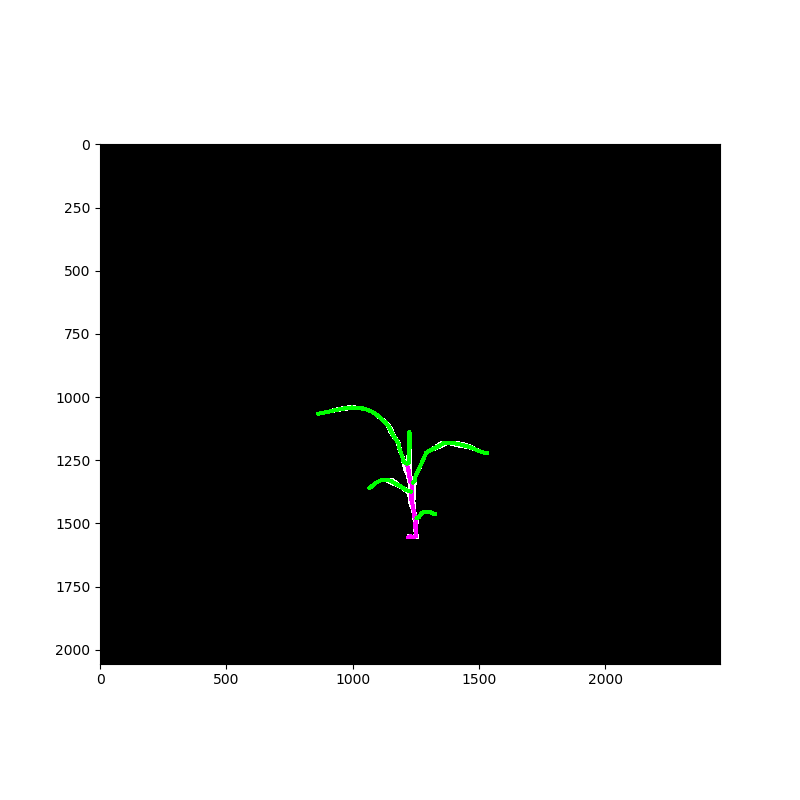

In [63]:
leaf_objects, other_objects = pcv.morphology.segment_sort(skel_img=pruned, objects=segment_objects, mask=mask)

Label the segment unique IDs

***

<IPython.core.display.Javascript object>


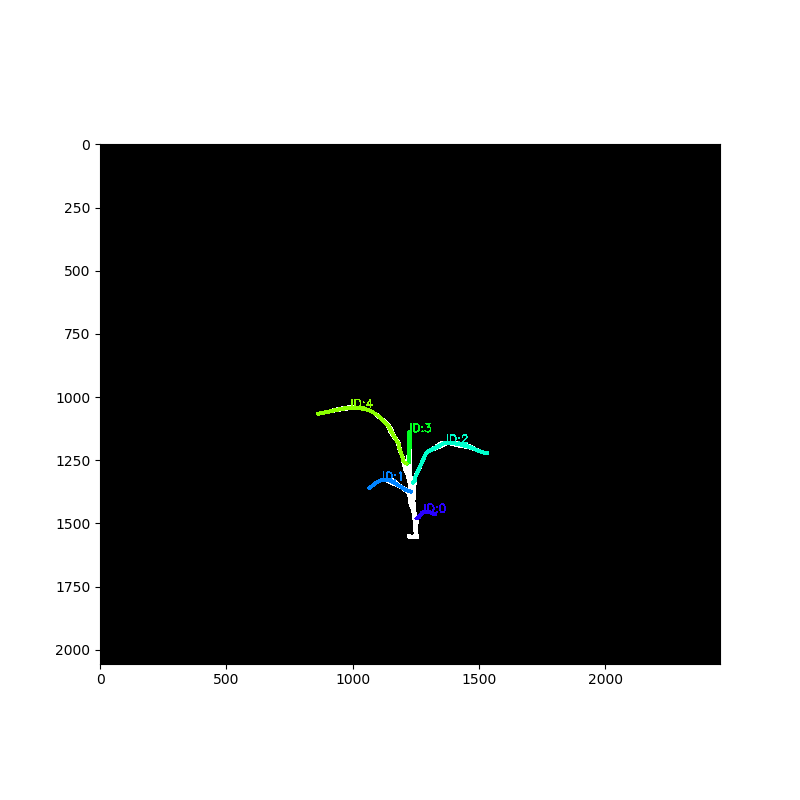

In [64]:
segmented_img, labeled_id_img = pcv.morphology.segment_id(skel_img=pruned, objects=leaf_objects, mask=mask)

Measure leaf insertion angles. Measures the angle between a line fit through the stem paths and a line fit through the first `size` points of each leaf path

***

<IPython.core.display.Javascript object>


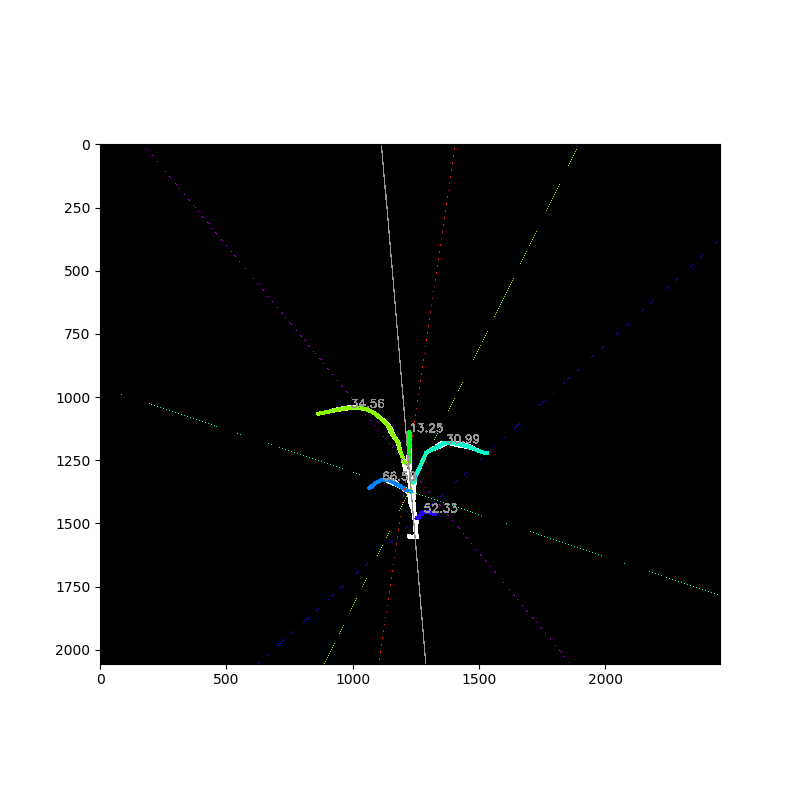

In [65]:
labeled_angle_img = pcv.morphology.segment_insertion_angle(skel_img=pruned, segmented_img=segmented_img, leaf_objects=leaf_objects, stem_objects=other_objects, size=22)

## Other potential morphological measurements

There are many other functions that extract data from within the morphology sub-package of PlantCV. For our purposes, we are most interested in the relative angle between each leaf and the stem which we measure with `plantcv.morphology.segment_insertion_angle`. However, the following cells show some of the other traits that we are able to measure from images that can be succesfully sorted into primary and secondary segments. 

Segment the plant binary mask using the leaf and stem segments. Allows for the measurement of individual leaf areas

***

<IPython.core.display.Javascript object>


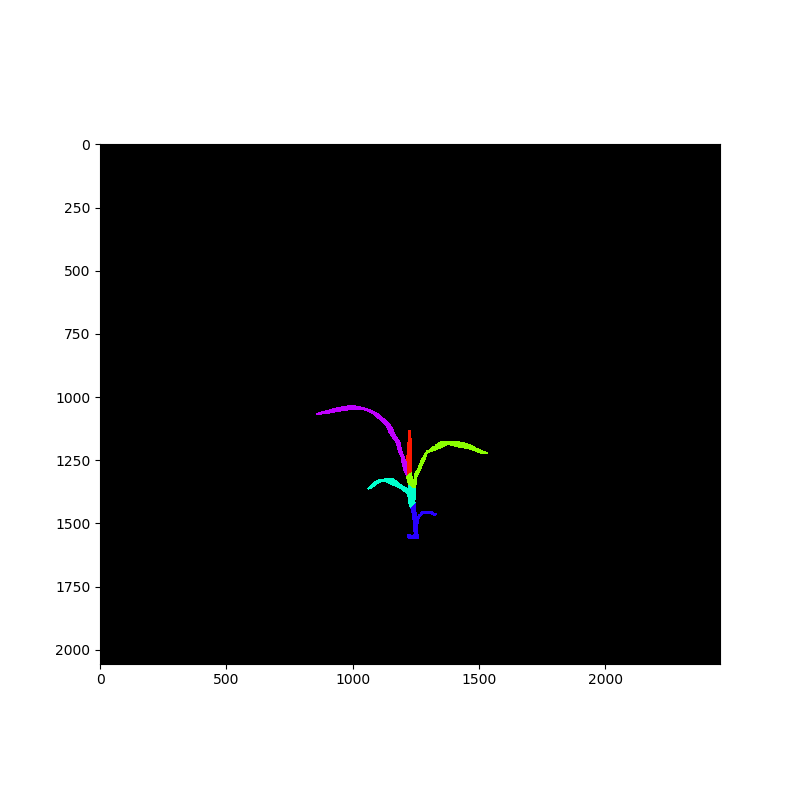

In [66]:
filled_img = pcv.morphology.fill_segments(mask=mask, objects=leaf_objects)

Measure the path length of each leaf (geodesic distance)

***

<IPython.core.display.Javascript object>


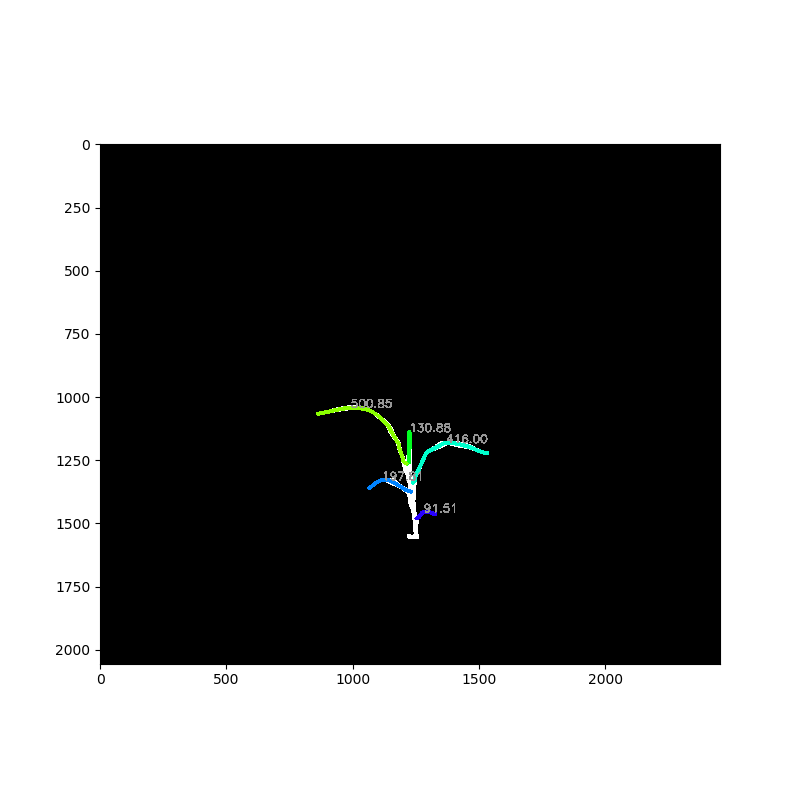

In [67]:
labeled_img2 = pcv.morphology.segment_path_length(segmented_img=segmented_img, objects=leaf_objects)

Measure the straight-line, branch point to tip distance (Euclidean) for each leaf

***

<IPython.core.display.Javascript object>


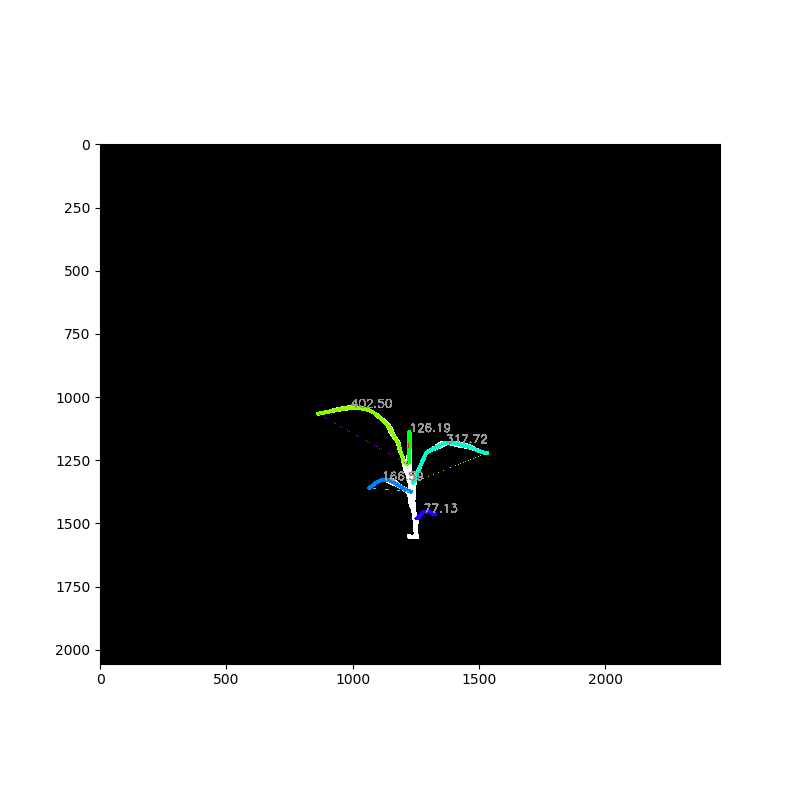

In [68]:
labeled_img3 = pcv.morphology.segment_euclidean_length(segmented_img=segmented_img, objects=leaf_objects)

Measure the curvature of each leaf (Values closer to 1 indicate that a segment is a straight line while larger values indicate the segment has more curvature)

***

<IPython.core.display.Javascript object>


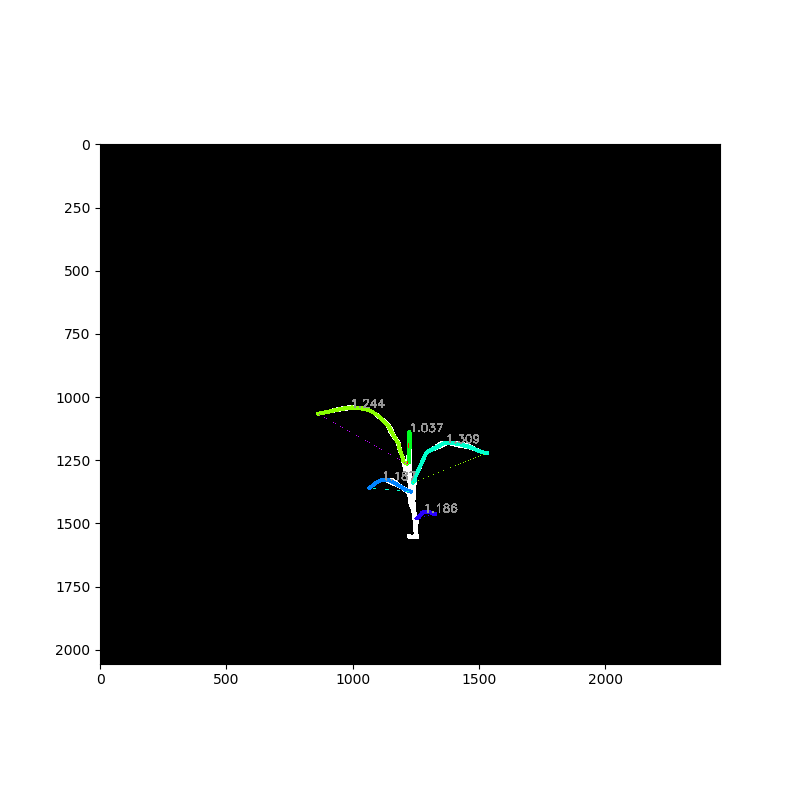

In [69]:
labeled_img4 = pcv.morphology.segment_curvature(segmented_img=segmented_img, objects=leaf_objects)

Measure absolute leaf angles (angle of linear regression line fit to each leaf object)

Note: negative values signify leaves to the left of the stem, positive values signify leaves to the right of the stem

***

<IPython.core.display.Javascript object>


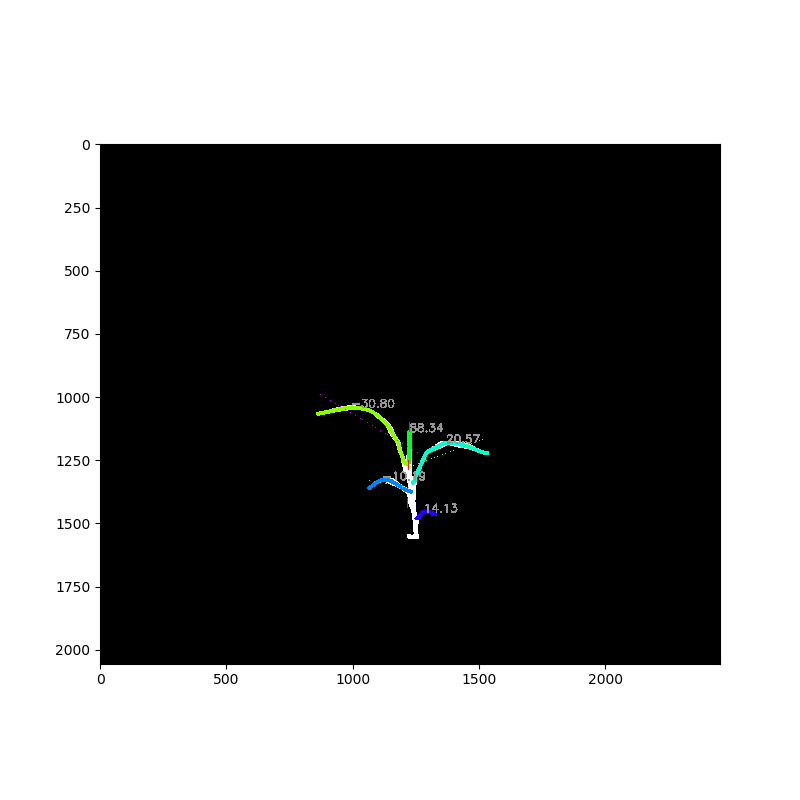

In [70]:
labeled_img5 = pcv.morphology.segment_angle(segmented_img=segmented_img, objects=leaf_objects)

Measure leaf curvature in degrees

***

<IPython.core.display.Javascript object>


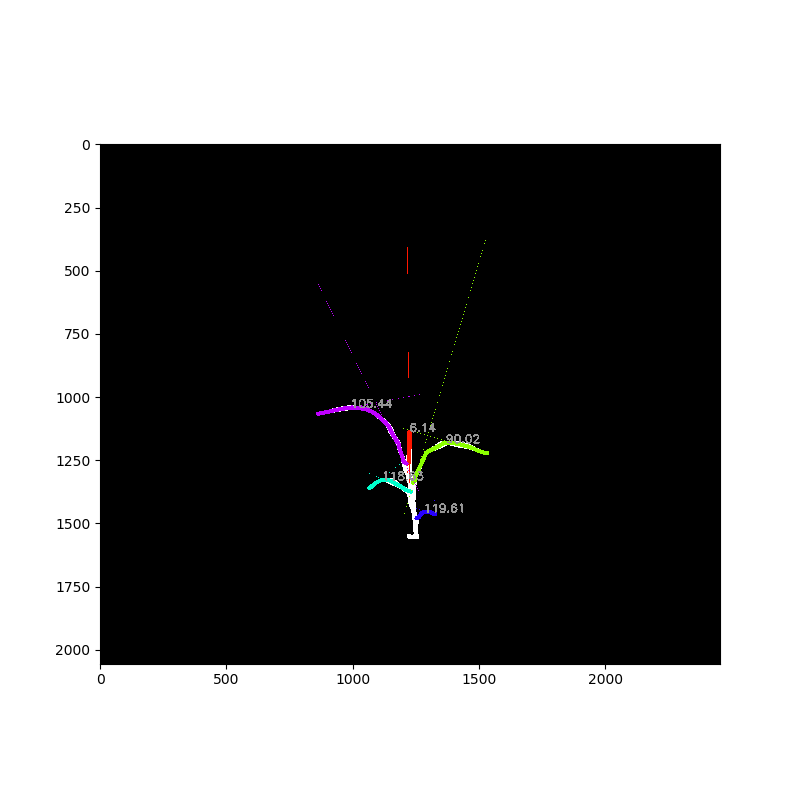

In [71]:
labeled_img6 = pcv.morphology.segment_tangent_angle(segmented_img=segmented_img, objects=leaf_objects, size=35)

Measure stem characteristics like stem angle and length

***

<IPython.core.display.Javascript object>


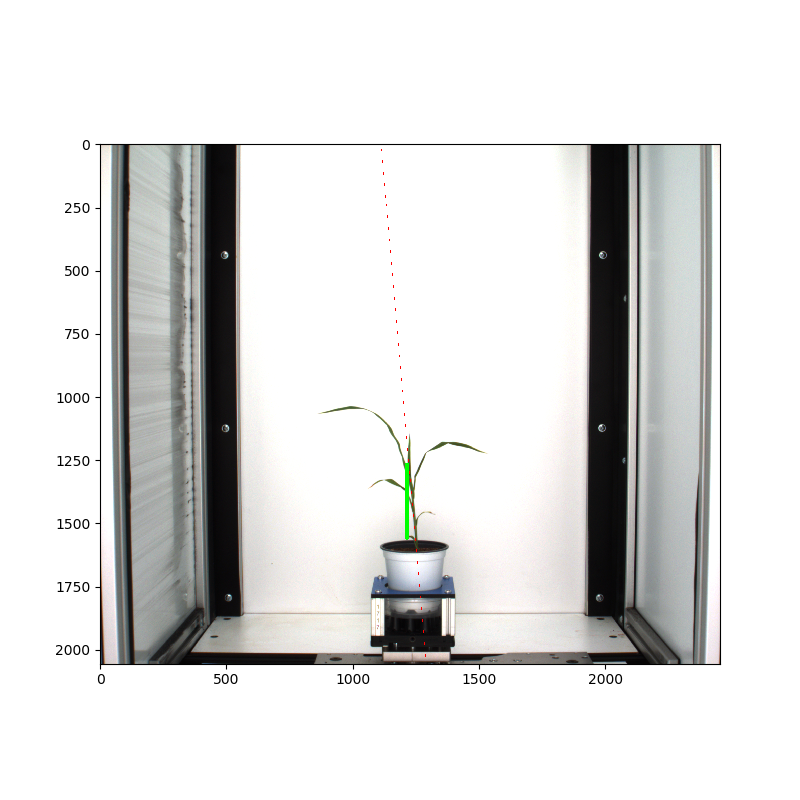

In [72]:
stem_img = pcv.morphology.analyze_stem(rgb_img=img, stem_objects=other_objects)

## Save the results out to file for downsteam analysis

In [73]:
pcv.print_results(filename=args.result)